# Greek Parliament Proceedings

You will work with a dataset containing Greek Parliament proceedings, available at <https://zenodo.org/record/2587904>. The dataset is described in Zenodo; you can also read <https://lab.imedd.org/en/parliamentary-minutes-from-1989-until-today/>.

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr


## Data Selection and Preparation

As you will find out, the dataset is extensive, as it contains three decades worth of parliamentary proceedings. You can restrict yourself to a subset of the dataset, however that subset must not be trivial. Also keep in mind that a dataset that is too small may be fast to process, but may not be enough to produce good results.

You are free to preprocess the data in any way that seems meaningful and that is likely to be conducive to good results. For instance, you may or may not remove punctuation, stopwords, very frequent or very rare words, etc. You can use any library for preprocessing, like [NLTK](https://www.nltk.org/) or [spaCy](https://spacy.io/); spaCy is more modern and faster. When developing the neural network solution you may do the preprocessing beforehand and / or using the TensorFlow facilities.

In [1]:
#necessary imports for conection with drive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
import pandas as pd
import numpy as np
import seaborn

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
#df = pd.read_csv('Greek_Parliament_Proceedings_1989_2019.csv') 
df = pd.read_csv('https://zenodo.org/record/2587904/files/Greek_Parliament_Proceedings_1989_2019.csv.zip?download=1',compression='zip') 

In [4]:
df['political_party'] = df['political_party'].replace('ανεξαρτητοι ελληνες - πανος καμμενος', 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια')

In [5]:
df['sitting_date'] = pd.to_datetime(df['sitting_date'], format="%Y-%m-%d")
df['sitting_date'][9500]
df.dtypes

member_name                      object
sitting_date             datetime64[ns]
parliamentary_period             object
parliamentary_session            object
parliamentary_sitting            object
political_party                  object
speaker_info                     object
speech                           object
dtype: object

## Data Exploration

* Expore the dataset to get an overall idea of what it is about. Think about:

  * Speeches per party.
  
  * Speeches over time.
  
  * Speeches per party and time.
  
  * Speakers per party.
  
  * Etc.
  
* Your analysis can (and should) include tables and diagrams.

In [6]:
df['political_party'] = df['political_party'].replace( 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)','πανελληνιο σοσιαλιστικο κινημα')
df['political_party'].unique()

array(['πανελληνιο σοσιαλιστικο κινημα', 'βουλη', 'νεα δημοκρατια',
       'κομμουνιστικο κομμα ελλαδας εσωτερικου',
       'κομμουνιστικο κομμα ελλαδας',
       'συνασπισμος της αριστερας των κινηματων και της οικολογιας', nan,
       'λαικος ορθοδοξος συναγερμος',
       'οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)',
       'ανεξαρτητοι (εκτος κομματος)', 'δημοκρατικη ανανεωση',
       'αντιπολιτευση', 'πολιτικη ανοιξη', 'δημοκρατικο κοινωνικο κινημα',
       'συνασπισμος ριζοσπαστικης αριστερας', 'δημοκρατικη αριστερα',
       'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
       'ανεξαρτητοι δημοκρατικοι βουλευτες',
       'λαικος συνδεσος - χρυση αυγη', 'το ποταμι', 'λαικη ενοτητα',
       'ενωση κεντρωων'], dtype=object)

In [7]:
df = df[df['sitting_date'].dt.year >= 2004]

In [8]:
partygroup = df[['political_party','speech']].groupby('political_party').count().reset_index()

In [9]:
partygroup = partygroup[partygroup['speech'] > df.shape[0]*0.5/100]

In [10]:
df = df[df['political_party'].isin(partygroup['political_party'])]

In [11]:
df = df[~df['political_party'].isin(["ανεξαρτητοι (εκτος κομματος)"])]

In [12]:
partylist = df['political_party'].unique()
partylist = partylist.tolist()
df['political_party'] = df['political_party'].apply(lambda x: partylist.index(x))
df = df.reset_index(drop=True)

Let's get a bit deeper to our words' analytics. <br>NOTE: This analysis is written after running initial classification models and while approaching the neural network models' implementation<br><br> (The cli module is imported, because google colab couldn't locate the el_core_news_sm model if it was downloaded through bash commands)

In [13]:
import spacy
import nltk
nltk.download('punkt')
import spacy.cli
spacy.cli.download("el_core_news_sm")
sp = spacy.load('el_core_news_sm')
from nltk.tokenize import word_tokenize
import string

all_stopwords = sp.Defaults.stop_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


In [14]:
def tokstoprem(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = []
    for word in text_tokens:
        word = word.lower()
        if ((not word in all_stopwords) & (not word in string.punctuation) & (not word.isnumeric()) & ( word.isalnum())):
            tokens_without_sw.append(word)
    #tokens_without_sw= [word.lower() for word in text_tokens if ((not word in all_stopwords) & (not word in string.punctuation) & (not word.isnumeric()))]
    return tokens_without_sw
tester0 = tokstoprem(df['speech'][0])
print(df['speech'][0])
tester0

 Σε δύο ενότητες πότε, κύριε Υπουργέ; Σήμερα;


['δύο', 'ενότητες', 'κύριε', 'υπουργέ', 'σήμερα']

In [15]:
df['speech'][0]

' Σε δύο ενότητες πότε, κύριε Υπουργέ; Σήμερα;'

In [16]:
df = df.dropna(subset=['speech'])
df['speech'] = df['speech'].apply(lambda x: tokstoprem(x))

Now let's go a bit further, and see the length of each sentence. This will help us decide the max length of each sentence before we encode them to numerical and import our padding, when we classify with neural networks (and using keras preprocessor)

In [17]:
df['speech'].apply(lambda x: len(x)).describe(percentiles=[0.2, 0.25,0.5,0.75,0.9, .95, .98, .99])

count    673014.000000
mean         62.072828
std         158.942359
min           0.000000
20%           2.000000
25%           2.000000
50%           6.000000
75%          26.000000
90%         198.000000
95%         394.000000
98%         575.000000
99%         755.000000
max        9054.000000
Name: speech, dtype: float64

As explained in the detailed preprocessing document, we'll remove speeches wth less than 4 words

In [18]:
df = df[df['speech'].apply(lambda x: len(x)) > 4]
len(df)

372975

And let's run the statistics distribution again

In [19]:
df['speech'].apply(lambda x: len(x)).describe(percentiles=[0.2, 0.25,0.5,0.75,0.9, .95, .98, .99])

count    372975.000000
mean        110.393970
std         200.864179
min           5.000000
20%           7.000000
25%           8.000000
50%          19.000000
75%         123.000000
90%         367.000000
95%         515.000000
98%         727.000000
99%         914.000000
max        9054.000000
Name: speech, dtype: float64

Let's try and initially set a sample max length of 125, 900, and None (grid search approach)

So, we have almost 400.000 samples. Let's see now what happens with our features, our individual words, which will be our vocabulary

In [20]:
from collections import Counter

counter  = Counter()
for i in df['speech']:
    counter.update(i)

There are quite common words, but it would actually be a never-ending spiral of what consitutes a "meaninful" token within the political context, without trial and error (out of our scope for now). We'll just assume that since the usage is so often, pretty much everyone uses them. In our traditional ML models, we'll even limit the document frequency, so trivial tokens will be removed anyways :)<br><br>
An interesting concept would be to differently treat the text within the greek quotation marks (removed earlier, since we have filtered out any non alphanumerical words),since it might be a bit confusing for our models, in case the quotations include phrases previously used by other parties (eg. refering to a sentence before responding to it). We could also extract it to a different column, and import it as seperate input to our models, in case we find any pattern on what different political parties tend to refer to. We will not be doing this however, due to time limitations. Just food for thought as next steps. We might update our stopwords, and re-filter our tokens before feeding them to our NN models, but not quite yet

In [21]:
len(counter)

316512

We have about 300k words in total. We'll have to keep that in mind, since they only give a ratio of samples/features of 1.x <br>
We might need to find a rule for features reduction for our NNs (traditional ML is protected by the max_df parameter). Let's see the most common ones

In [22]:
counter.most_common(50)

[('κύριε', 317727),
 ('ή', 198169),
 ('υπάρχει', 170465),
 ('σήμερα', 155704),
 ('κυβέρνηση', 150692),
 ('συνάδελφοι', 150335),
 ('κύριοι', 149421),
 ('λόγο', 127711),
 ('πρόεδρε', 118905),
 ('υπουργέ', 114726),
 ('άρθρο', 114031),
 ('θέμα', 109821),
 ('δύο', 105596),
 ('χώρα', 104243),
 ('χρόνια', 103535),
 ('αφορά', 101621),
 ('ευχαριστώ', 100174),
 ('νομοσχέδιο', 99519),
 ('ευρώ', 98903),
 ('πολιτική', 98032),
 ('πω', 94628),
 ('γίνεται', 91386),
 ('κυρίες', 90499),
 ('υπάρχουν', 88449),
 ('κάνει', 88375),
 ('διότι', 84774),
 ('γίνει', 83937),
 ('σ', 75973),
 ('ελλάδα', 71971),
 ('νέα', 71699),
 ('δημοκρατίας', 70980),
 ('θέλω', 69079),
 ('χώρας', 68446),
 ('υπουργός', 67574),
 ('συζήτηση', 65007),
 ('τρόπο', 63802),
 ('λέει', 62669),
 ('κι', 62408),
 ('νέας', 62280),
 ('βεβαίως', 59422),
 ('βουλή', 58878),
 ('πρόβλημα', 58777),
 ('υπουργό', 58511),
 ('επιτροπή', 58228),
 ('υπουργείο', 58084),
 ('στιγμή', 57106),
 ('κυρία', 54816),
 ('ό', 54422),
 ('κυβέρνησης', 54412),
 ('κάνουμε',

And let's see how many document frequency we have for each word, a metric that will help us set a better value to the max_df parameter of our traditional ML models

In [23]:
counter  = Counter()
for i in df['speech'].apply(lambda x: (set(x))):
    counter.update(i)

In [24]:
pd.DataFrame.from_dict(dict(counter), orient='index').describe(percentiles=[0.25,0.5,0.75,0.8, 0.9,  0.92, .95,  0.97 ,.98,.985, .99])

,0
count,316512.000000
mean,99.148105
std,1040.658482
min,1.000000
25%,1.000000
50%,3.000000
75%,13.000000
80%,22.000000
90%,81.000000
92%,117.000000


80% of the words appear in up to 22 documents.
<br>Based on the above results, we'll use as a starting point two alternative approaches:<br>1. A vocab based on 3-5% of our total terms when training our NN models (so well try to start with a 20k vocabulary)<br> 2. A vocab based on the total of existing words<br>
<br> The last table also suggests that our initial attempts to traditional ML models, with min_df hyperparameter set to a percentage of the total documents (.1, .05), was way too strict and limited down on way too few words.
<br> (NOTE: the initial attempts were set before the word-level pre-processing, making it even more strict)

In [25]:
counter.most_common(50)

[('κύριε', 182156),
 ('λόγο', 108855),
 ('πρόεδρε', 90083),
 ('ευχαριστώ', 81922),
 ('συνάδελφοι', 79414),
 ('ή', 78204),
 ('υπάρχει', 77776),
 ('κύριοι', 77438),
 ('σήμερα', 69340),
 ('γίνεται', 66223),
 ('δύο', 63251),
 ('κυβέρνηση', 62036),
 ('υπουργέ', 61602),
 ('θέμα', 58177),
 ('πω', 57243),
 ('χρόνια', 53057),
 ('αφορά', 52492),
 ('κυρίες', 52071),
 ('κάνει', 51533),
 ('γίνει', 51233),
 ('υπάρχουν', 49919),
 ('άρθρο', 48780),
 ('διότι', 47735),
 ('υπουργός', 47552),
 ('χώρα', 46518),
 ('πολιτική', 45047),
 ('θέλω', 44929),
 ('συζήτηση', 44367),
 ('νομοσχέδιο', 43628),
 ('δημοκρατίας', 42549),
 ('τρόπο', 42431),
 ('σ', 40966),
 ('κυρία', 40469),
 ('βουλή', 39984),
 ('σώμα', 39834),
 ('νέας', 39549),
 ('νέα', 39272),
 ('ήθελα', 38553),
 ('κι', 37659),
 ('υπουργό', 37470),
 ('στιγμή', 37390),
 ('χώρας', 37008),
 ('χρόνο', 36420),
 ('λέει', 36341),
 ('ό', 35704),
 ('ελλάδα', 35513),
 ('ευχαριστούμε', 34651),
 ('κάνουμε', 34637),
 ('ευρώ', 34180),
 ('κυβέρνησης', 33732)]

We see many similarities (expectedly) between words; absolute frequency and words' document frequency. We will not act God here (although sometimes we need to during such processes). We will only remove a few words, which are surely menaingless.
<br> We also observe that the largest document frequency is 182156/372975= 0.488, and reaching down to our 50th most common word, we're already down to less than 1/10th of the total docs' frequency. This is an upper-limit indicator of the words' sparcity. Derived from this, we'll set our initial max_df hyperparameters to 0.5, 0.35 (none to some upper limit restriction) and work from there <br>
NOTE: The already ran traditional ML models before this analysis are left for thought-process purposes.

In [26]:
additional_stopwords = ['κι', 'ό', 'σ', 'ή']
def speedtok(listed):
    tokens_without_sw= [word for word in listed if not (word in additional_stopwords)]
    return tokens_without_sw
df['speech']=df['speech'].apply(lambda x: speedtok(x))

## Classification with a Neural Network

* Carry out classification, but this time using a neural network.

For memory efficiency, we keep only tour two main columns

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import sklearn
from tensorflow.keras.preprocessing.text import Tokenizer

df = df[['speech','political_party']]

In [28]:
df.head(3)

,speech,political_party
0,"[δύο, ενότητες, κύριε, υπουργέ, σήμερα]",0
1,"[ενότητα, σήμερα, δεύτερη, τροπολογίες, υπάρχουν]",1
2,"[πάρτε, κύριε, πρόεδρε, σύμβαση, tvx, ολόκληρο...",0


Unfortunately, it is way more difficult to work witl lists of strings as input for our neural networks. We can only encode them with multilabelbinarizer from ScikitLearn, which turns them to sparce patrices (onehot encoding option is non viable for our HW, and not efficient in general for the whole dataset). So, we need to turn each speech to string again

In [29]:
def unifier(tlist):
  retstr =" "
  return (retstr.join(tlist))
df['speech'] = df['speech'].apply(lambda x: unifier(x))

In [30]:
df['speech'][0]

'δύο ενότητες κύριε υπουργέ σήμερα'

In [31]:
import tensorflow as tf
max_features = 20000
embedding_dim = 64
sequence_length = 500

def custom_standardization(input_data):
    return input_data
#We'll paraelly approach vectorize_layer and pre-processing data with the Tokenizer class, importing them straight to the embeddings layer
tokenizer = Tokenizer(num_words=max_features, filters='', lower=False)
#We will train the Tokenizer on the whole of our speeches dataset
tokenizer.fit_on_texts(df['speech'].values)
vectorize_layer = TextVectorization(standardize=custom_standardization,max_tokens=max_features,output_mode="int",output_sequence_length=sequence_length)

In [32]:
X = tokenizer.texts_to_sequences(df['speech'].values)
X = pad_sequences(X, maxlen=sequence_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (372975, 500)


In [33]:
y = pd.get_dummies(df['political_party']).values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(335677, 500) (335677, 11)
(37298, 500) (37298, 11)


In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 800

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
378/378 [==============================] - 2209s 6s/step - loss: 1.6855 - accuracy: 0.3782 - val_loss: 1.4297 - val_accuracy: 0.4553
Epoch 2/10
378/378 [==============================] - 2213s 6s/step - loss: 1.3715 - accuracy: 0.4920 - val_loss: 1.3201 - val_accuracy: 0.5099
Epoch 3/10
378/378 [==============================] - 2220s 6s/step - loss: 1.2368 - accuracy: 0.5516 - val_loss: 1.3245 - val_accuracy: 0.5153
Epoch 4/10
378/378 [==============================] - 2219s 6s/step - loss: 1.2105 - accuracy: 0.5648 - val_loss: 1.2441 - val_accuracy: 0.5420
Epoch 5/10
378/378 [==============================] - 2216s 6s/step - loss: 1.1366 - accuracy: 0.5877 - val_loss: 1.2161 - val_accuracy: 0.5470
Epoch 6/10
378/378 [==============================] - 2208s 6s/step - loss: 1.0920 - accuracy: 0.6026 - val_loss: 1.3402 - val_accuracy: 0.5290
Epoch 7/10
378/378 [==============================] - 2185s 6s/step - loss: 1.1618 - accuracy: 0.5849 - val_loss: 1.2161 - val_accuracy:

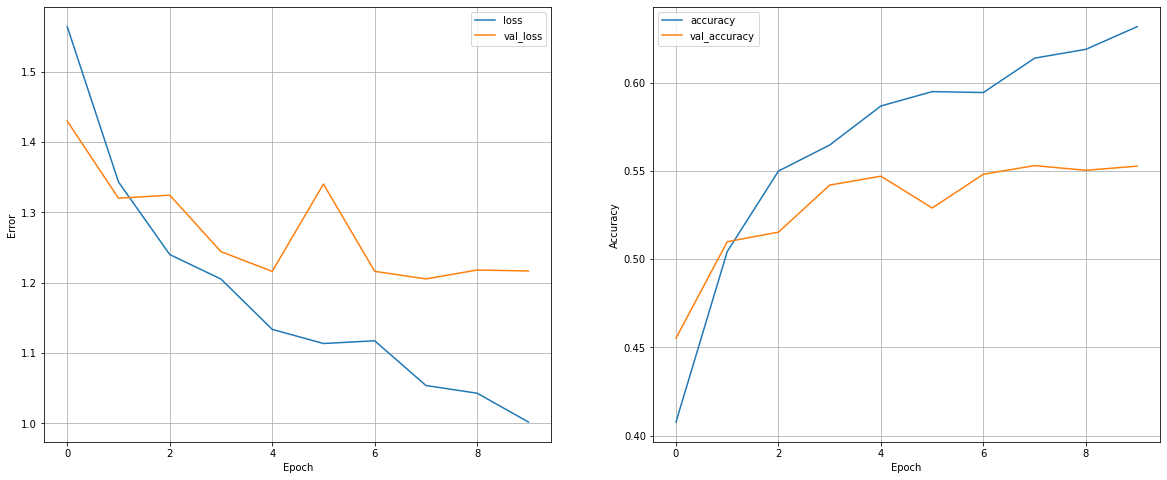

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
result = model.evaluate(X_test,y_test)

1166/1166 [==============================] - 111s 95ms/step - loss: 1.2249 - accuracy: 0.5557


In [ ]:
print("We got a loss of "+str(result[0])+" and an accuracy score of "+str(result[1])+" for our testing data")

We got a loss of 1.2248629331588745 and an accuracy score of 0.5556866526603699 for our testing data


#### Second Model attemt - RNN

In [ ]:
embedding_dim=64
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D
from keras.optimizers import Adam
import tensorflow as tf

model2 = Sequential()
model2.add(Embedding(max_features, embedding_dim, input_length=X.shape[1]))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model2.add(Dense(len(df['political_party'].unique()), activation='softmax'))
model2.compile(optimizer=Adam(0.015), loss='categorical_crossentropy', metrics=['accuracy'])
history_rnn = model2.fit(X_train, y_train, epochs=10, batch_size=800, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

Epoch 1/10
336/336 [==============================] - 2333s 7s/step - loss: 1.5306 - accuracy: 0.4195 - val_loss: 1.2212 - val_accuracy: 0.5429
Epoch 2/10
336/336 [==============================] - 4916s 15s/step - loss: 1.1235 - accuracy: 0.5835 - val_loss: 1.1666 - val_accuracy: 0.5615
Epoch 3/10
336/336 [==============================] - 5255s 16s/step - loss: 0.9721 - accuracy: 0.6393 - val_loss: 1.1937 - val_accuracy: 0.5609
Epoch 4/10
336/336 [==============================] - 5196s 15s/step - loss: 0.8677 - accuracy: 0.6781 - val_loss: 1.2482 - val_accuracy: 0.5544


In [ ]:
result_rnn = model2.evaluate(X_test,y_test)

1166/1166 [==============================] - 129s 111ms/step - loss: 1.2495 - accuracy: 0.5519


1.24952232837677

We have marginally worse accuracy from our initial attempt. That shouldn't be the case, since we have applied more sophisticated and suitable techniques to our model. Before we play with the actual parameters of the odel, let's see if the early stopping was too strict. We'll increase our early stop patience from 2 to 4 epochs, and decrease the minimum delta of variance to half ( So, we're trying to see if there might be sth significantly better than our local optimal solution)

In [ ]:
embedding_dim=64
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D
from keras.optimizers import Adam
import tensorflow as tf

model2 = Sequential()
model2.add(Embedding(max_features, embedding_dim, input_length=X.shape[1]))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model2.add(Dense(len(df['political_party'].unique()), activation='softmax'))
model2.compile(optimizer=Adam(0.015), loss='categorical_crossentropy', metrics=['accuracy'])
history_rnn2 = model2.fit(X_train, y_train, epochs=10, batch_size=800, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.00005)])

Epoch 1/10
336/336 [==============================] - 2541s 8s/step - loss: 1.5214 - accuracy: 0.4203 - val_loss: 1.2337 - val_accuracy: 0.5387
Epoch 2/10
336/336 [==============================] - 2765s 8s/step - loss: 1.1368 - accuracy: 0.5786 - val_loss: 1.1606 - val_accuracy: 0.5632
Epoch 3/10
336/336 [==============================] - 2687s 8s/step - loss: 0.9804 - accuracy: 0.6358 - val_loss: 1.1826 - val_accuracy: 0.5604
Epoch 4/10
336/336 [==============================] - 2519s 7s/step - loss: 0.8680 - accuracy: 0.6798 - val_loss: 1.2510 - val_accuracy: 0.5544
Epoch 5/10
336/336 [==============================] - 2497s 7s/step - loss: 0.7913 - accuracy: 0.7078 - val_loss: 1.3071 - val_accuracy: 0.5474
Epoch 6/10
336/336 [==============================] - 2498s 7s/step - loss: 0.7317 - accuracy: 0.7307 - val_loss: 1.3637 - val_accuracy: 0.5425


In [ ]:
result2 = model2.evaluate(X_test,y_test)
print("We got a loss of "+str(result2[0])+" and an accuracy score of "+str(result2[1])+" for our testing data")

1166/1166 [==============================] - 127s 109ms/step - loss: 1.3673 - accuracy: 0.5448
We got a loss of 1.3673385381698608 and an accuracy score of 0.5447745323181152 for our testing data


The results are not encouraging at all. What we need to do, despite the fact that in theory, such a model is more promising for our analysis.
<br>
There are a few ways we can act on such a situation. Due to time restrictions, we will only state them for now.

1. Add more hidden layers
2. Increase our neurons size
3. change our activation functions

In other cases, we might thought of focusing on fixing our samples (changing vocab size, sequence length, oversampling of classes, creating synthetic data, or including more data from the ones we filtered out - mainly with our chronological criterion). However, we already have a marginally better performance with a simler model, so for sure our starting point should be the model itself.


### Code graveyard (non working code attempts)

In [ ]:
from keras.utils.np_utils import to_categorical

max_len = 900

labels = to_categorical(df['political_party'])


In [ ]:
n_most_common_words = 20000
token_filter = ''
tokenizer = Tokenizer(num_words=n_most_common_words, filters=token_filter, lower=False)
tokenizer.fit_on_texts(df['speech'].values)

In [ ]:
sequences = tokenizer.texts_to_sequences(df['speech'].values)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.2, random_state=42)

In [ ]:
epochs = 10
emb_dim = 64
batch_size = 256
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((305839,), (305839,), (67136,), (67136,))


In [ ]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
training = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

IndexError: ignored

creating an input pipeline from df to dataset

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('political_party')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset